In [16]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
# %matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, train_test_split

text_mining_keywords = ['cochera', 'sum', 'parrilla', 'pileta']


def vectorize_descripcion(df: pd.DataFrame):
    descripcion = df['descripcion']
    descripcion[descripcion.isna()] = ''

    
    # entrenamos el modelo para buscar las keywords
    vectorizer = CountVectorizer(binary=True)  
    vectorizer.fit(text_mining_keywords)

    # hot encoding de los resultados
    df_countvectorizer = vectorizer.transform(descripcion)

    desc = pd.DataFrame(df_countvectorizer.toarray())
    desc.columns = text_mining_keywords
    
    df.drop(['descripcion'], axis=1, inplace=True)
    return(pd.concat([df, desc], axis=1))
    

def preprocessing(df: pd.DataFrame):
    # guardar los id
    ids = df['id']

    # eliminar columnas innecesarias del modelo
    df.drop(['id', 'pub_inicio', 'pub_fin', 'pub_creada', 'subbarrio', 'titulo', 'barrio', 'BARRIO', 'COMUNA', 'n_uni',
       'n_boliches', 'n_clinicas', 'n_hospitales', 'n_comisarias',
       'n_embajadas', 'n_subte_bocas', 'n_barrios_p', 'n_homicidios',
       'n_hurtos', 'n_hurtos_auto', 'n_robo', 'n_robo_vehi', 'n_atm', 'n_bici',
       'n_bancos', 'n_hotel_Alta', 'n_hotel_Media', 'n_hotel_Baja',
       'n_gasolina', 'n_gastronomica'],axis=1, inplace=True, errors='ignore')

    # df.rename(columns={'BARRIO':'barrio'}, inplace=True)

    df = vectorize_descripcion(df)

    return ids, df


def split_data(df: pd.DataFrame, test_size = 0.05):
    y = df['precio']
    X = df.drop(['precio'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=5)
    return X_train, X_test, y_train, y_test


## Preprocesamiento de los features: imputación, estandarización, one-hot encoding
def make_transformer_pipeline():
    numeric_features = ['lat', 'lon', 'habitaciones', 'dormitorios', 'banios',
       'sup_total', 'sup_cubierta', 'cochera', 'sum', 'parrilla',
       'pileta']
    numeric_transformer = make_pipeline( 
        SimpleImputer(missing_values = np.nan, strategy='mean'),
        StandardScaler(),
    )

    categorical_features = ['barrio']
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        #SimpleImputer(strategy="most_frequent"),
        #KNNImputer(n_neighbors=3, weights="uniform"),     # KNNImputer tarda una eternidad...
        OneHotEncoder(handle_unknown='ignore')
    )

    return make_column_transformer(
        (numeric_transformer, numeric_features),
        # (categorical_transformer, categorical_features)
    )    

def baseline_rfr_model_pipeline():
    transformer = make_transformer_pipeline()
    rfr = RandomForestRegressor(n_estimators=300, max_depth=28, random_state = 5)
    
    return make_pipeline(transformer, rfr)

def create_train_rfr_model():
    transformer = make_transformer_pipeline()

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(RandomForestRegressor(random_state=5), transformer=StandardScaler()))
    ])
    return model

def create_train_svr_model():
    transformer = make_transformer_pipeline()
    svr = SVR(C=1)

    pipeline = make_pipeline(transformer, svr)
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return model    

def create_train_lr_model():
    transformer = make_transformer_pipeline()
    lr = LinearRegression()

    pipeline = make_pipeline(transformer, lr)
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return model    

def plot_test_predictions(y_test, y_pred):
    # # graficar predicciones contra datos actuales
    # plt.figure(figsize = (18,10))
    # plot_k = sns.scatterplot(y_test, y_pred)
    # plot_k.set(xlabel='Precio test', ylabel='Precio predicción')
    # # graficar la identidad
    # x_plot = np.linspace(0,np.max(y_test),1000)
    # y_plot = x_plot
    # plt.plot(x_plot, y_plot, color='r')

    fig, ax = plt.subplots(figsize = (18,10))
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Precio test')
    ax.set_ylabel('Precio predicción')
    plt.show()



In [5]:
df_train = pd.read_csv('data_def.csv', sep=';', decimal=',')
df_train.head()

,id,pub_inicio,pub_fin,pub_creada,lat,lon,barrio,subbarrio,habitaciones,dormitorios,...,n_robo,n_robo_vehi,n_atm,n_bici,n_bancos,n_hotel_Alta,n_hotel_Media,n_hotel_Baja,n_gasolina,n_gastronomica
0,1,2019-11-20,9999-12-31,2019-11-20,-34.606891,-58.409890,Almagro,NaN,3.0,NaN,...,1604,4,16,0,11,0,0,0,4,13
1,3,2019-11-19,2020-02-22,2019-11-19,-34.604912,-58.417065,Almagro,NaN,3.0,1.0,...,952,1,10,2,7,0,0,0,2,1
2,4,2019-05-21,2019-07-03,2019-05-21,-34.600886,-58.431204,Villa Crespo,NaN,3.0,2.0,...,467,6,4,1,3,0,0,0,0,20
3,5,2019-05-21,2020-05-22,2019-05-21,-34.628760,-58.453224,Flores,NaN,4.0,3.0,...,442,4,12,0,10,0,0,0,2,10
4,6,2019-07-15,2020-02-13,2019-07-15,-34.572144,-58.480173,Villa Urquiza,NaN,3.0,NaN,...,209,0,0,1,0,0,0,0,1,2


In [6]:
df_train.columns

Index(['id', 'pub_inicio', 'pub_fin', 'pub_creada', 'lat', 'lon', 'barrio',
       'subbarrio', 'habitaciones', 'dormitorios', 'banios', 'sup_total',
       'sup_cubierta', 'titulo', 'descripcion', 'precio', 'BARRIO', 'COMUNA',
       'n_uni', 'n_boliches', 'n_clinicas', 'n_hospitales', 'n_comisarias',
       'n_embajadas', 'n_subte_bocas', 'n_barrios_p', 'n_homicidios',
       'n_hurtos', 'n_hurtos_auto', 'n_robo', 'n_robo_vehi', 'n_atm', 'n_bici',
       'n_bancos', 'n_hotel_Alta', 'n_hotel_Media', 'n_hotel_Baja',
       'n_gasolina', 'n_gastronomica'],
      dtype='object')

In [7]:
ids, df_train = preprocessing(df_train)

In [8]:
df_train.head()

,lat,lon,habitaciones,dormitorios,banios,sup_total,sup_cubierta,precio,cochera,sum,parrilla,pileta
0,-34.606891,-58.409890,3.0,NaN,2.0,108.0,108.0,150000.0,0,0,0,0
1,-34.604912,-58.417065,3.0,1.0,2.0,72.0,63.0,144000.0,1,0,0,0
2,-34.600886,-58.431204,3.0,2.0,1.0,57.0,57.0,145000.0,0,0,0,0
3,-34.628760,-58.453224,4.0,3.0,3.0,128.0,117.0,585000.0,0,0,1,0
4,-34.572144,-58.480173,3.0,NaN,2.0,NaN,60.0,237000.0,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = split_data(df_train)

# Grid search para encontrar los mejores parámetros Random Forest 

In [104]:


# Entrenar modelo RandomForestRegressor con búsqueda de hiperparámetros
tuned_parameters = {'model__regressor__n_estimators': [300], 
                    'model__regressor__max_depth': [30, 40],
                    'model__regressor__max_features': ['sqrt', 'log2'],
                    # 'model__regressor__max_samples': [10000, 25000],
                    'model__regressor__min_samples_leaf': [1, 2],
                    'model__regressor__min_samples_split': [2, 3]}
model_rfr = create_train_rfr_model()
model = GridSearchCV(model_rfr, tuned_parameters, n_jobs=2, scoring='neg_root_mean_squared_error', refit='neg_root_mean_squared_error', verbose=5)
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 12.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [105]:
print("Mejores parámetros encontrados RandomForestRegressor:")
print()
print(model.best_params_)
print()
print("Scores:")
print(model.best_score_)

Mejores parámetros encontrados RandomForestRegressor:

{'model__regressor__max_depth': 40, 'model__regressor__max_features': 'sqrt', 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 2, 'model__regressor__n_estimators': 300}

Scores:
-118607.78176797021


In [106]:
model_rfr.set_params(**model.best_params_)
model_rfr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                   

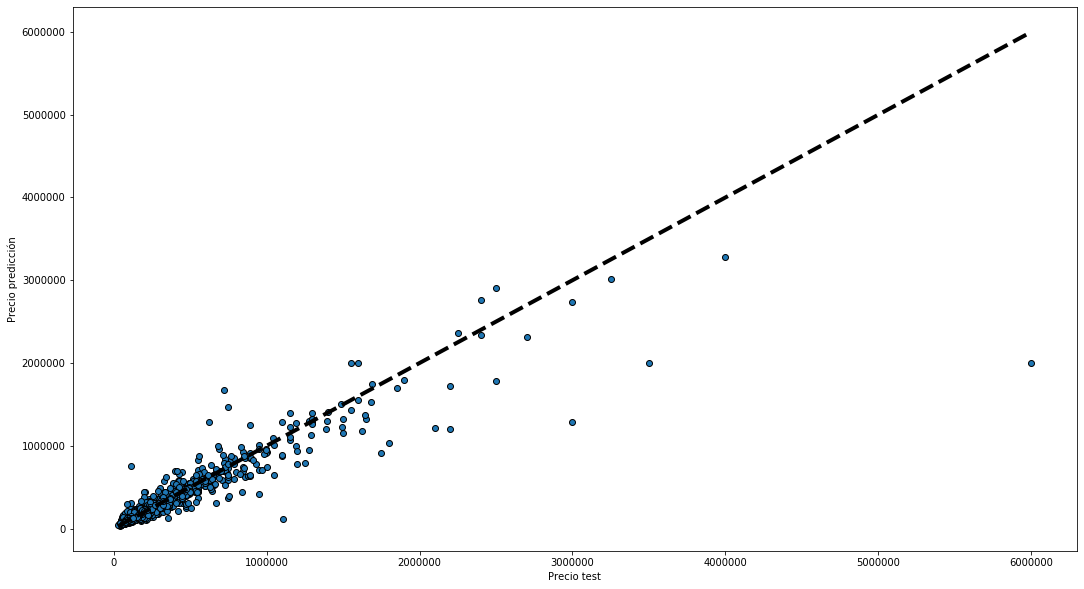

In [107]:
y_pred = model_rfr.predict(X_test)
plot_test_predictions(y_test, y_pred)

# Baseline Random Forest

In [10]:
model_rfr = baseline_rfr_model_pipeline()         # -118157.51541951629

In [11]:
scores = cross_val_score(model_rfr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
scores

array([-114130.38580416, -111954.21782714, -137498.15723521,
       -101741.45287422, -125463.36335685])

In [12]:
np.average(scores)

-118157.51541951629

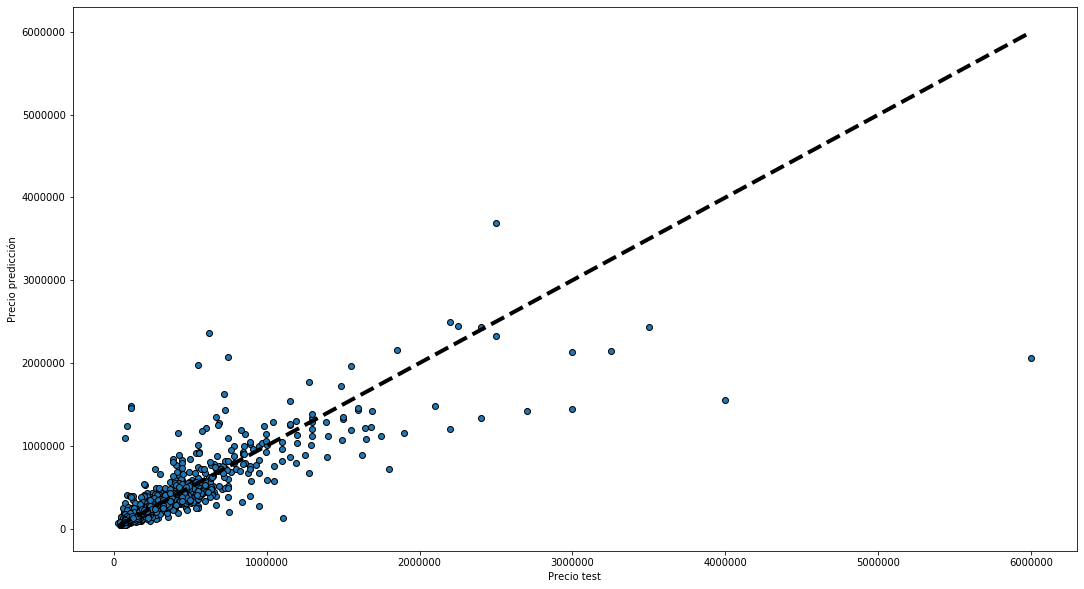

In [13]:
y_pred = cross_val_predict(model_rfr, X_test, y_test, cv=5)
plot_test_predictions(y_test, y_pred)

# Predicción en el set de test

In [17]:
df_test = pd.read_csv('data_test.csv', sep=';', decimal=',')
df_test.head()

,id,pub_inicio,pub_fin,pub_creada,lat,lon,barrio,subbarrio,habitaciones,dormitorios,...,n_robo,n_robo_vehi,n_atm,n_bici,n_bancos,n_hotel_Alta,n_hotel_Media,n_hotel_Baja,n_gasolina,n_gastronomica
0,2,2019-10-23,9999-12-31,2019-10-23,-34.586330,-58.508957,Villa Devoto,NaN,1.0,NaN,...,130,3,1,0,0,0,0,0,0,1
1,34,2019-05-07,2019-06-23,2019-05-07,-34.581699,-58.433547,Palermo,Palermo Hollywood,1.0,1.0,...,276,2,6,1,0,0,0,0,3,78
2,54,2019-10-13,2019-12-23,2019-10-13,-34.628187,-58.429586,Caballito,NaN,2.0,1.0,...,333,20,4,1,3,0,0,0,2,21
3,101,2019-08-25,2019-09-14,2019-08-25,-34.593716,-58.440695,Palermo,NaN,2.0,1.0,...,345,1,4,0,3,0,0,0,1,7
4,103,2019-10-23,2019-11-09,2019-10-23,-34.591336,-58.447218,Villa Crespo,NaN,2.0,1.0,...,280,0,4,1,0,0,0,0,2,4


In [18]:
ids, df_test = preprocessing(df_test)

In [20]:
df_test.drop(['precio'], axis=1, inplace=True)
df_test.head()

,lat,lon,habitaciones,dormitorios,banios,sup_total,sup_cubierta,cochera,sum,parrilla,pileta
0,-34.586330,-58.508957,1.0,NaN,NaN,45,37,0,0,0,0
1,-34.581699,-58.433547,1.0,1.0,1.0,53,40,1,0,0,0
2,-34.628187,-58.429586,2.0,1.0,1.0,42,38,0,1,0,0
3,-34.593716,-58.440695,2.0,1.0,1.0,62,38,0,0,0,0
4,-34.591336,-58.447218,2.0,1.0,1.0,44,40,1,0,0,0


In [22]:
model_rfr.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                               

In [23]:
predicted = model_rfr.predict(df_test)
data = pd.DataFrame(data={'id' : ids.values, 'precio': np.round(predicted).astype(int) })

In [24]:
data


,id,precio
0,2,111887
1,34,218239
2,54,131105
3,101,131573
4,103,120595
...,...,...
2495,53190,128007
2496,53221,296128
2497,53233,108902
2498,53243,133908


In [25]:
# from google.colab import files
data.to_csv('propiedades_prediccion.csv', index=False)
# files.download('propiedades_prediccion.csv')